#Setup
Import libraries and data

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import seaborn as sns

In [12]:
# run this if you are using colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [16]:
# if this does not run, change to the file path where ALL is located on your device
!unzip /content/gdrive/MyDrive/ALL.zip

Archive:  /content/gdrive/MyDrive/ALL.zip
   creating: ALL/early/
replace ALL/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [17]:
data_dir = 'ALL'

#Data Processing
Split data into training, validation, and testing sets

In [18]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
SEED = 123

full_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

# Get class names from the full dataset before splitting
class_names = full_ds.class_names
num_classes = len(class_names)
print("\nClasses:", class_names)


dataset_size = tf.data.experimental.cardinality(full_ds).numpy()

train_size = int(0.7 * dataset_size)
val_size   = int(0.15 * dataset_size)
test_size  = dataset_size - train_size - val_size  # ensures exact total

train_ds = full_ds.take(train_size)
temp_ds  = full_ds.skip(train_size)

val_ds = temp_ds.take(val_size)
test_ds = temp_ds.skip(val_size)

train_ds = train_ds.shuffle(5000)

print("\nTrain batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())

for i, class_name in enumerate(class_names):
  print(f"Label {i}: {class_name}")

Found 20001 files belonging to 5 classes.

Classes: ['all_benign', 'all_early', 'all_pre', 'all_pro', 'early']

Train batches: 438
Val batches: 93
Test batches: 95
Label 0: all_benign
Label 1: all_early
Label 2: all_pre
Label 3: all_pro
Label 4: early


In [19]:
for name, ds in [("train", train_ds), ("val", val_ds), ("test", test_ds)]:
    labels = []
    for _, y in ds:
        labels.extend(y.numpy())
    print(name, np.bincount(labels))

train [3497 3514 3523 3482]
val [768 741 737 730]
test [736 750 739 784]


In [20]:
# normalize the data so that values are [0,1] instead of [0,255]
# improves convergence speed and ensures consistency among all features
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [21]:
for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels:", labels.numpy()[:50])

unique, counts = np.unique(labels.numpy(), return_counts=True)
print(dict(zip(unique, counts)))

Images shape: (32, 128, 128, 3)
Labels: [0 3 1 3 3 0 1 2 3 3 2 1 3 1 2 2 3 1 2 0 3 2 2 1 1 1 1 0 0 3 2 1]
{np.int32(0): np.int64(5), np.int32(1): np.int64(10), np.int32(2): np.int64(8), np.int32(3): np.int64(9)}


In [22]:
# BEFORE normalization
raw_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle=False,
    image_size=(128, 128),
    batch_size=32
)

for imgs, labs in raw_ds.take(1):
    print("RAW range:", imgs.numpy().min(), imgs.numpy().max())
    break

# AFTER normalization (your actual dataset)
for imgs, labs in train_ds.take(1):
    print("AFTER range:", imgs.numpy().min(), imgs.numpy().max())
    break


Found 20001 files belonging to 5 classes.
RAW range: 0.0 255.0
AFTER range: 0.0 1.0


#CNN Models and Training Performance
Model implementation, training, and validation performance visualization


In [23]:
num_classes = 4  # benign, early, pre, pro
epochs = 50

# 2 convolution layers and a max pooling layer
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=IMG_SIZE + (3,)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # multi-class
])

model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

history1 = model1.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early_stopping])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
 59/438 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.4213 - loss: 6.1752

KeyboardInterrupt: 

In [ ]:
model1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,530,254 (360.60 MB)

 Trainable params: 31,510,084 (120.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,020,170 (240.40 MB)

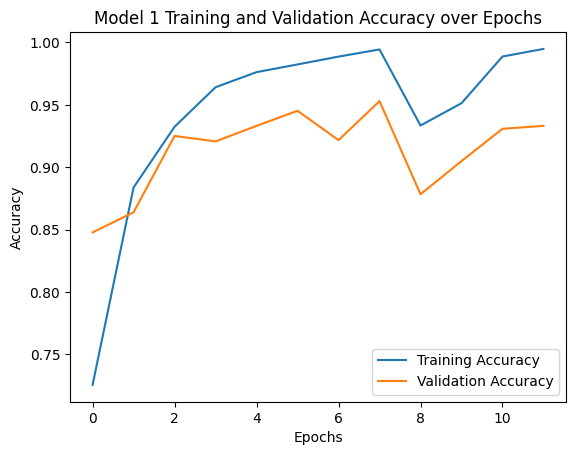

In [ ]:
train_acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']
epochs_trained = len(train_acc1)

plt.plot(range(epochs_trained), train_acc1, label='Training Accuracy')
plt.plot(range(epochs_trained), val_acc1, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model 1 Training and Validation Accuracy over Epochs")
plt.legend()
plt.show()

In [ ]:
# 2 convolution layers and a max pooling layer and 25% dropout
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=IMG_SIZE + (3,)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # multi-class
])

model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

history2 = model2.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early_stopping])

Epoch 1/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 26s 46ms/step - accuracy: 0.6228 - loss: 2.0429 - val_accuracy: 0.8538 - val_loss: 0.3358
Epoch 2/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.9160 - loss: 0.2155 - val_accuracy: 0.9338 - val_loss: 0.1777
Epoch 3/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.9566 - loss: 0.1248 - val_accuracy: 0.9237 - val_loss: 0.2057
Epoch 4/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.9721 - loss: 0.0830 - val_accuracy: 0.9526 - val_loss: 0.1334
Epoch 5/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.9742 - loss: 0.0756 - val_accuracy: 0.9351 - val_loss: 0.1870
Epoch 6/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - accuracy: 0.9779 - loss: 0.0676 - val_accuracy: 0.9570 - val_loss: 0.1197
Epoch 7/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - accuracy: 0.9995 - loss: 0.0034 - val_accuracy: 0.9120 - val_loss: 0.3254
Epoch 8/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.8955 - loss: 0.3339 - 

In [ ]:
model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,530,254 (360.60 MB)

 Trainable params: 31,510,084 (120.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,020,170 (240.40 MB)

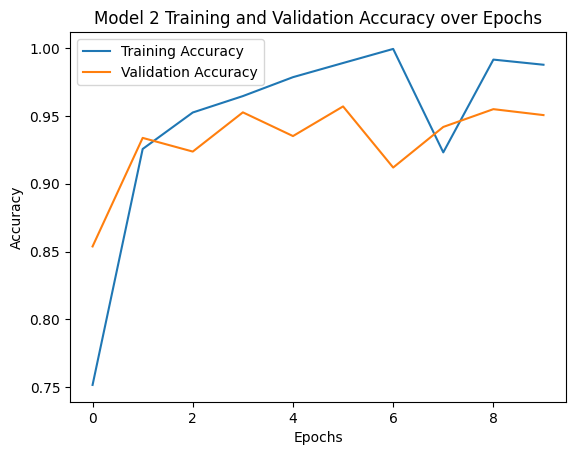

In [ ]:
train_acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
epochs_trained = len(train_acc2)

plt.plot(range(epochs_trained), train_acc2, label='Training Accuracy')
plt.plot(range(epochs_trained), val_acc2, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model 2 Training and Validation Accuracy over Epochs")
plt.legend()
plt.show()

In [41]:
# 4 convolution layers, 2 max pooling layers, and 2 25% dropout layers
model3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=IMG_SIZE + (3,)),

    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

history3 = model3.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early_stopping])

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 82s 134ms/step - accuracy: 0.5480 - loss: 0.9629 - val_accuracy: 0.8565 - val_loss: 0.4140
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 76s 130ms/step - accuracy: 0.8686 - loss: 0.3482 - val_accuracy: 0.9459 - val_loss: 0.1491
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 76s 130ms/step - accuracy: 0.9201 - loss: 0.2077 - val_accuracy: 0.9546 - val_loss: 0.1258
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 76s 130ms/step - accuracy: 0.9601 - loss: 0.1079 - val_accuracy: 0.9835 - val_loss: 0.0507
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 76s 130ms/step - accuracy: 0.9686 - loss: 0.0840 - val_accuracy: 0.9735 - val_loss: 0.0710
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 76s 129ms/step - accuracy: 0.9751 - loss: 0.0757 - val_accuracy: 0.9876 - val_loss: 0.0376
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 76s 129ms/step - accuracy: 0.9840 - loss: 0.0438 - val_accuracy: 0.9842 - val_loss: 0.0458
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 76s 129ms/step - accuracy: 0.9840 - loss: 0

In [42]:
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,365,710 (5.21 MB)

 Trainable params: 455,236 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 910,474 (3.47 MB)

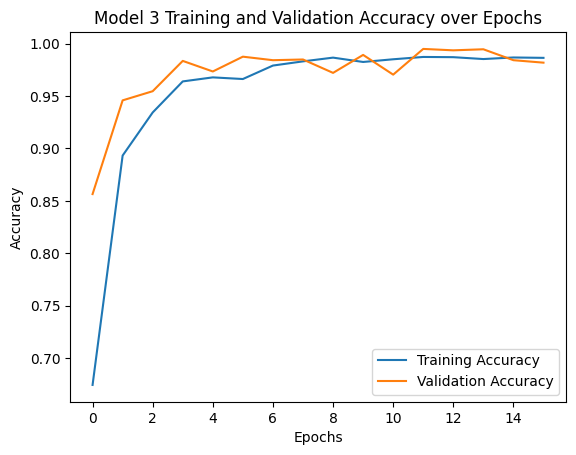

In [44]:
train_acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']
epochs_trained = len(train_acc3)

plt.plot(range(epochs_trained), train_acc3, label='Training Accuracy')
plt.plot(range(epochs_trained), val_acc3, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model 3 Training and Validation Accuracy over Epochs")
plt.legend()
plt.show()

# Make Predictions



In [46]:
# Ensure the test dataset is NOT shuffled and not repeated
test_ds_eval = test_ds.cache().prefetch(0)

# Extract true labels in the precise order the model sees them
true_labels = np.array([y.numpy() for _, y in test_ds_eval.unbatch()])

# pred_probs_1 = model1.predict(test_ds_eval)
# predicted_labels_1 = np.argmax(pred_probs_1, axis=1)

#pred_probs_2 = model2.predict(test_ds_eval)
#predicted_labels_2 = np.argmax(pred_probs_2, axis=1)

pred_probs_3 = model3.predict(test_ds_eval)
predicted_labels_3 = np.argmax(pred_probs_3, axis=1)

95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

acc1 = accuracy_score(true_labels, predicted_labels_1)
acc2 = accuracy_score(true_labels, predicted_labels_2)
acc3 = accuracy_score(true_labels, predicted_labels_3)

f1_1 = f1_score(true_labels, predicted_labels_1, average="macro")
f1_2 = f1_score(true_labels, predicted_labels_2, average="macro")
f1_3 = f1_score(true_labels, predicted_labels_3, average="macro")

print("===== MODEL 1 (No Dropout) =====")
print(f"Accuracy: {acc1:.4f}")
print(f"Macro F1: {f1_1:.4f}")
print(classification_report(true_labels, predicted_labels_1))

print("\n===== MODEL 2 (Dropout) =====")
print(f"Accuracy: {acc2:.4f}")
print(f"Macro F1: {f1_2:.4f}")
print(classification_report(true_labels, predicted_labels_2))

print("\n== MODEL 3 (More Convoultion + Dropout) ==")
print(f"Accuracy: {acc3:.4f}")
print(f"Macro F1: {f1_3:.4f}")
print(classification_report(true_labels, predicted_labels_3))


===== MODEL 1 (No Dropout) =====
Accuracy: 0.9191
Macro F1: 0.9173
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       745
           1       0.86      0.88      0.87       749
           2       0.96      0.96      0.96       757
           3       0.96      1.00      0.98       789

    accuracy                           0.92      3040
   macro avg       0.92      0.92      0.92      3040
weighted avg       0.92      0.92      0.92      3040


===== MODEL 2 (Dropout) =====
Accuracy: 0.9549
Macro F1: 0.9544
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       745
           1       0.92      0.94      0.93       749
           2       0.99      0.96      0.98       757
           3       0.97      1.00      0.99       789

    accuracy                           0.95      3040
   macro avg       0.95      0.95      0.95      3040
weighted avg       0.96      0.95      0.95      3040

# Generating and Plotting Confusion Matrices

In [ ]:
# Generate confusion matrices for model performance
cm1 = confusion_matrix(true_labels, predicted_labels_1)
cm2 = confusion_matrix(true_labels, predicted_labels_2)
cm3 = confusion_matrix(true_labels, predicted_labels_3)

class_names = ["benign", "early", "pre", "pro"]

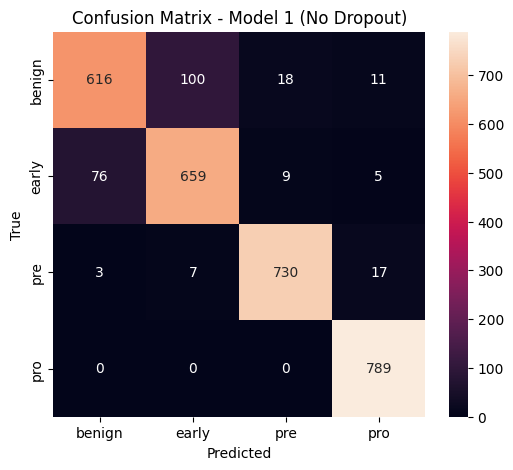

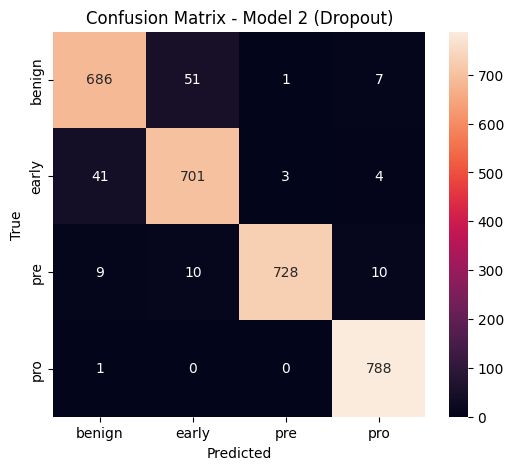

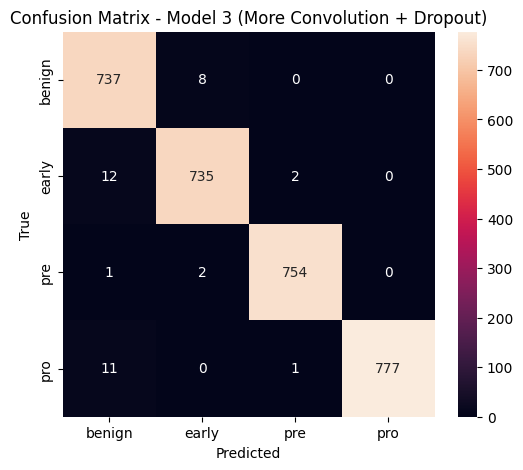

In [ ]:
plt.figure(figsize=(6,5))
sns.heatmap(cm1, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Model 1 (No Dropout)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(cm2, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Model 2 (Dropout)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(cm3, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Model 3 (More Convolution + Dropout)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



#Visualizing a CNN layer applied to a single image

In [ ]:
# Take one batch from the test dataset
for images, labels in train_ds.take(1):
    # Select the first image from the batch
    sample_image = images[0]
    # Expand dimensions to create a batch of size 1
    sample_image = tf.expand_dims(sample_image, axis=0)

print(sample_image.shape)

(1, 128, 128, 3)


# Extract the output of the convolutional layer
Create a new model that outputs the result of the chosen convolutional layer and apply the filter to the sample image


In [ ]:
conv_layer_name = 'conv2d'
feature_map_model = tf.keras.models.Model(inputs=model1.inputs, outputs=model1.get_layer(conv_layer_name).output)
feature_map_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896 (3.50 KB)

 Trainable params: 896 (3.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
feature_maps = feature_map_model.predict(sample_image)
print(feature_maps.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
(1, 126, 126, 32)


## Visualize the generated feature maps

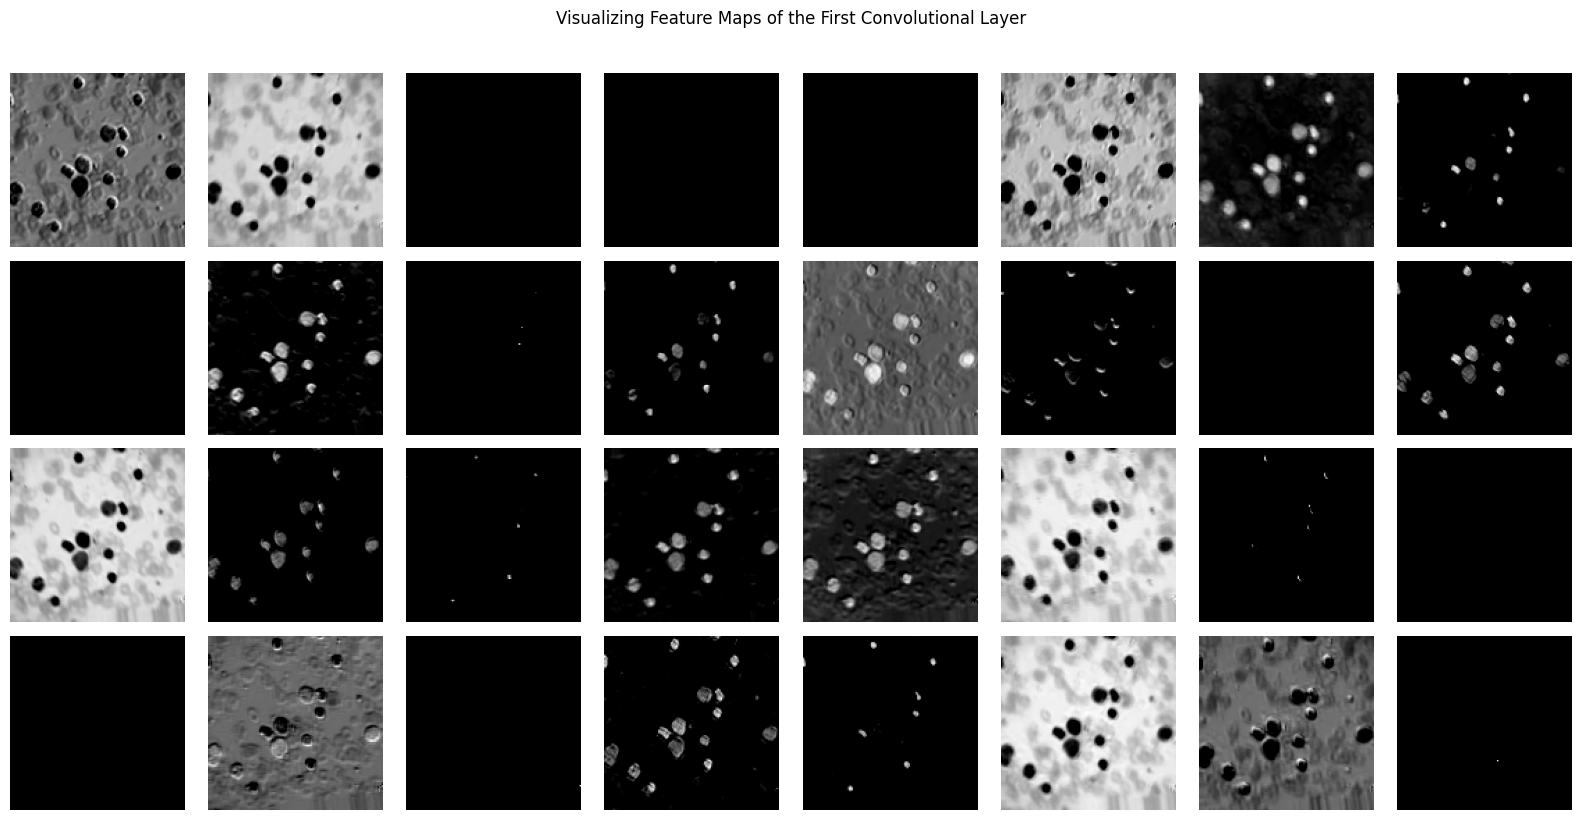

In [ ]:
num_feature_maps = feature_maps.shape[-1]
cols = 8
rows = (num_feature_maps + cols - 1) // cols

plt.figure(figsize=(cols * 2, rows * 2))

for i in range(num_feature_maps):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(feature_maps[0, :, :, i], cmap='gray') # Display the i-th feature map
    plt.axis('off')

plt.suptitle("Visualizing Feature Maps of the First Convolutional Layer", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
from sklearn.metrics import confusion_matrix

def interactive_feature_maps(model, image):
    # Extract first conv layer output
    layer = model.layers[1]   # adjust index for first Conv2D
    feature_model = tf.keras.Model(inputs=model.input, outputs=layer.output)

    feature_maps = feature_model.predict(image[None, ...])[0]
    num_filters = feature_maps.shape[-1]

    # Create slider-enabled interactive visualization
    fig = px.imshow(feature_maps[..., 0], binary_string=True)
    fig.update_layout(
        title="Feature Map Explorer",
        xaxis_title="Width",
        yaxis_title="Height",
        sliders=[{
            "steps": [{
                "method": "update",
                "args": [{"z": [feature_maps[..., i]]}],
                "label": f"Filter {i}"
            } for i in range(num_filters)]
        }]
    )
    fig.show()

def plot_training_interactive(history):
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=history.history["accuracy"], mode='lines+markers', name='Train Acc'))
    fig.add_trace(go.Scatter(y=history.history["val_accuracy"], mode='lines+markers', name='Val Acc'))
    fig.update_layout(
        title="Interactive Accuracy Plot",
        xaxis_title="Epoch",
        yaxis_title="Accuracy",
        hovermode="x unified"
    )
    fig.show()

def interactive_confusion_matrix(true_labels, pred_labels, class_names):
    cm = confusion_matrix(true_labels, pred_labels)
    fig = px.imshow(
        cm, text_auto=True, color_continuous_scale='Blues',
        labels=dict(x="Predicted", y="Actual"),
        x=class_names, y=class_names
    )
    fig.update_layout(title="Interactive Confusion Matrix")
    fig.show()

for images, labels in test_ds_eval.take(1):
        sample_image = images[0].numpy()
        interactive_feature_maps(model3, sample_image)
plot_training_interactive(model3.history)
interactive_confusion_matrix(test_ds_eval, model3, class_names)

NameError: name 'test_ds_eval' is not defined

In [51]:
import tensorflow as tf

# Force-build the model if not already built
dummy = tf.zeros((1,) + IMG_SIZE + (3,), dtype=tf.float32)
_ = model3(dummy)   # this "calls" the model and defines model3.input

print(model3.built)      # should be True
print(model3.input_shape)
model3.summary()

for i, layer in enumerate(model3.layers):
    print(i, layer.name, layer.output_shape)


True
(None, 128, 128, 3)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,365,710 (5.21 MB)

 Trainable params: 455,236 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 910,474 (3.47 MB)

AttributeError: 'Conv2D' object has no attribute 'output_shape'

In [52]:
import tensorflow as tf
import numpy as np

IMG_SHAPE = IMG_SIZE + (3,)

# Reuse all layers except the last Dense(4) softmax
embedding_model = tf.keras.Sequential(model3.layers[:-1])

# Force-build the embedding model so it’s ready to use
dummy = tf.zeros((1,) + IMG_SHAPE, dtype=tf.float32)
_ = embedding_model(dummy)   # forward pass to build
embedding_model.summary()    # should end at dense_4 with output (None, 256)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (1, 128, 128, 32)      │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (1, 128, 128, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (1, 64, 64, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (1, 64, 64, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (1, 64, 64, 128)       │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (1, 64, 64, 256)       │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (1, 32, 32, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (1, 32, 32, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (1, 256)               │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (1, 256)               │        65,792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 454,208 (1.73 MB)

 Trainable params: 454,208 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
def get_embeddings_from_ds(dataset, embedding_model):
    feats = []
    labs  = []
    for batch_x, batch_y in dataset:
        z = embedding_model(batch_x, training=False)  # (batch, 256)
        feats.append(z.numpy())
        labs.append(batch_y.numpy())
    X = np.concatenate(feats, axis=0)   # (N, 256)
    y = np.concatenate(labs,  axis=0)   # (N,)
    return X, y

# e.g. use 128 batches of the training data
subset_train_ds = train_ds.take(128)

X_feat_train, y_train = get_embeddings_from_ds(subset_train_ds, embedding_model)
print(X_feat_train.shape, y_train.shape)


(4096, 256) (4096,)


In [65]:
import umap.umap_ as umap

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,   # or 3
    metric='euclidean',
    random_state=42
)

X_umap_train = reducer.fit_transform(X_feat_train)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


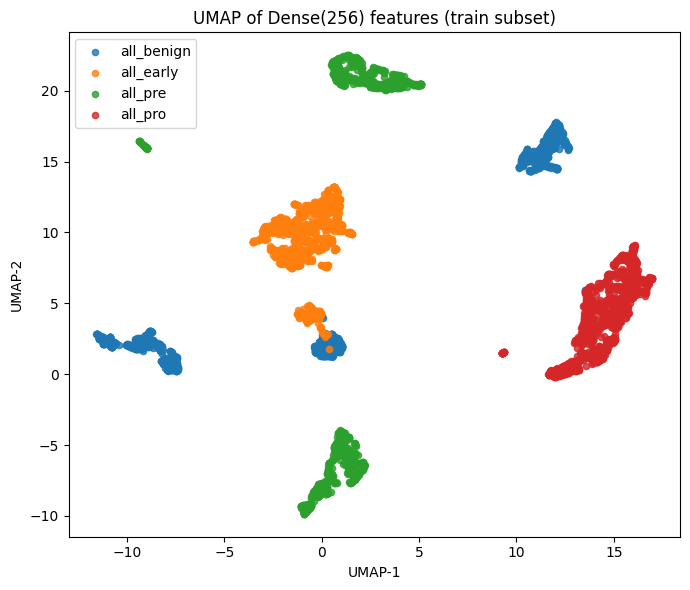

In [66]:
import numpy as np
import matplotlib.pyplot as plt

class_names = ['all_benign', 'all_early', 'all_pre', 'all_pro']

plt.figure(figsize=(7, 6))
for label in np.unique(y_train):
    idx = y_train == label
    plt.scatter(
        X_umap_train[idx, 0],
        X_umap_train[idx, 1],
        s=20,
        alpha=0.8,
        label=class_names[label]
    )

plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.title('UMAP of Dense(256) features (train subset)')
plt.legend()
plt.tight_layout()
plt.show()